# Inference on Predictive and Causal Effects in High-Dimensional Nonlinear Models

## Impact of 401(k) on  Financial Wealth

As a practical illustration of the methods developed in this lecture, we consider estimation of the effect of 401(k) eligibility and participation 
on accumulated assets. 401(k) plans are pension accounts sponsored by employers. The key problem in determining the effect of participation in 401(k) plans on accumulated assets is saver heterogeneity coupled with the fact that the decision to enroll in a 401(k) is non-random. It is generally recognized that some people have a higher preference for saving than others. It also seems likely that those individuals with high unobserved preference for saving would be most likely to choose to participate in tax-advantaged retirement savings plans and would tend to have otherwise high amounts of accumulated assets. The presence of unobserved savings preferences with these properties then implies that conventional estimates that do not account for saver heterogeneity and endogeneity of participation will be biased upward, tending to overstate the savings effects of 401(k) participation.

One can argue that eligibility for enrolling in a 401(k) plan in this data can be taken as exogenous after conditioning on a few observables of which the most important for their argument is income. The basic idea is that, at least around the time 401(k)’s initially became available, people were unlikely to be basing their employment decisions on whether an employer offered a 401(k) but would instead focus on income and other aspects of the job. 

### Data

The data set can be downloaded from the github repo


In [1]:
# Import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV, LinearRegression, Ridge, Lasso, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
import patsy
import warnings
from sklearn.base import BaseEstimator, clone
import statsmodels.api as sm
from IPython.display import Markdown
import wget
import os
import seaborn as sns
warnings.simplefilter('ignore')
np.random.seed(1234)

In [2]:
file = "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/401k.csv"
data = pd.read_csv(file)

In [3]:
data.describe()

,ira,a401,hval,hmort,hequity,nifa,net_nifa,tfa,net_tfa,tfa_he,...,i3,i4,i5,i6,i7,a1,a2,a3,a4,a5
count,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9.915000e+03,9.915000e+03,9.915000e+03,9.915000e+03,9.915000e+03,...,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000
mean,3462.871609,3990.459304,63595.865759,30022.505093,33573.360666,1.392864e+04,1.041415e+04,2.156603e+04,1.805153e+04,5.162490e+04,...,0.209178,0.172668,0.121432,0.158548,0.077358,0.144024,0.209682,0.297428,0.215431,0.133434
std,9648.027853,12825.840676,73679.374267,40056.879558,51830.770524,5.490488e+04,5.602886e+04,6.256504e+04,6.352250e+04,9.325339e+04,...,0.406742,0.377979,0.326645,0.365272,0.267171,0.351132,0.407102,0.457150,0.411142,0.340061
min,0.000000,0.000000,0.000000,0.000000,-40000.000000,0.000000e+00,-5.023020e+05,0.000000e+00,-5.023020e+05,-5.023020e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000e+02,-1.350000e+03,3.750000e+02,-5.000000e+02,2.000000e+02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,48000.000000,7000.000000,10000.000000,1.635000e+03,2.700000e+02,3.325000e+03,1.499000e+03,1.850000e+04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,200.000000,95000.000000,50000.000000,46650.000000,8.765500e+03,6.543500e+03,1.908450e+04,1.652450e+04,6.920000e+04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,100000.000000,153000.000000,300000.000000,150000.000000,300000.000000,1.430298e+06,1.430298e+06,1.536798e+06,1.536798e+06,1.687115e+06,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
data.head()

,ira,a401,hval,hmort,hequity,nifa,net_nifa,tfa,net_tfa,tfa_he,...,i3,i4,i5,i6,i7,a1,a2,a3,a4,a5
0,0,0,69000,60150,8850,100,-3300,100,-3300,5550,...,1,0,0,0,0,0,1,0,0,0
1,0,0,78000,20000,58000,61010,61010,61010,61010,119010,...,0,1,0,0,0,0,0,0,1,0
2,1800,0,200000,15900,184100,7549,7049,9349,8849,192949,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,0,0,2487,-6013,2487,-6013,-6013,...,0,0,1,0,0,1,0,0,0,0
4,0,0,300000,90000,210000,10625,-2375,10625,-2375,207625,...,0,1,0,0,0,0,0,1,0,0


In [5]:
readme = "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/401k.md"
filename = wget.download(readme)
display(Markdown(open(filename, 'r').read()))

100% [................................................................................] 2314 / 2314

# Pension 401(k) data set

## Description
Data set on financial wealth and 401(k) plan participation. The source of this data set is the `hdm` package in `R`. It was created on 2/20/2023, by calling the `data(pension)` command in `R` after loading the `hdm` package and then writing the created dataframe to a csv file.

## Format
Dataframe with the following variables (amongst others):

**p401**

participation in 401(k)

**e401**

eligibility for 401(k)

**a401**

401(k) assets

**tw**

total wealth (in US $)

**tfa**

financial assets (in US $)

**net_tfa**

net financial assets (in US $)

**nifa**

non-401k financial assets (in US $)

**net_nifa**

net non-401k financial assets

**net_n401**

net non-401(k) assets (in US $)

**ira**

individual retirement account (IRA)

**inc**

income (in US $)

**age**

age

**fsize**

family size

**marr**

married

**pira**

participation in IRA

**db**

defined benefit pension

**hown**

home owner

**educ**

education (in years)

**male**

male

**twoearn**

two earners

**nohs, hs, smcol, col**

dummies for education: no high-school, high-school, some college, college

**hmort**

home mortage (in US $)

**hequity**

home equity (in US $)

**hval**

home value (in US $)

## Details
The sample is drawn from the 1991 Survey of Income and Program Participation (SIPP) and consists of 9,915 observations. The observational units are household reference persons aged 25-64 and spouse if present. Households are included in the sample if at least one person is employed and no one is self-employed. The data set was analysed in Chernozhukov and Hansen (2004) and Belloni et al. (2014) where further details can be found. They examine the effects of 401(k) plans on wealth using data from the Survey of Income and Program Participation using 401(k) eligibility as an instrument for 401(k) participation.

## References
V. Chernohukov, C. Hansen (2004). The impact of 401(k) participation on the wealth distribution: An instrumental quantile regression analysis. The Review of Economic and Statistics 86 (3), 735â€“751.

A. Belloni, V. Chernozhukov, I. Fernandez-Val, and C. Hansen (2014). Program evaluation with high-dimensional data. Working Paper.

The data consist of 9,915 observations at the household level drawn from the 1991 Survey of Income and Program Participation (SIPP).  All the variables are referred to 1990. We use net financial assets (*net\_tfa*) as the outcome variable, $Y$,  in our analysis. The net financial assets are computed as the sum of IRA balances, 401(k) balances, checking accounts, saving bonds, other interest-earning accounts, other interest-earning assets, stocks, and mutual funds less non mortgage debts. 

Among the $9915$ individuals, $3682$ are eligible to participate in the program. The variable *e401* indicates eligibility and *p401* indicates participation, respectively.

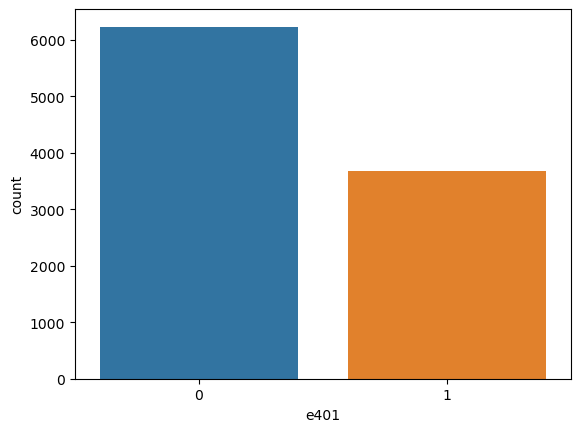

In [6]:
sns.countplot(data['e401'],)
plt.show()

Eligibility is highly associated with financial wealth:

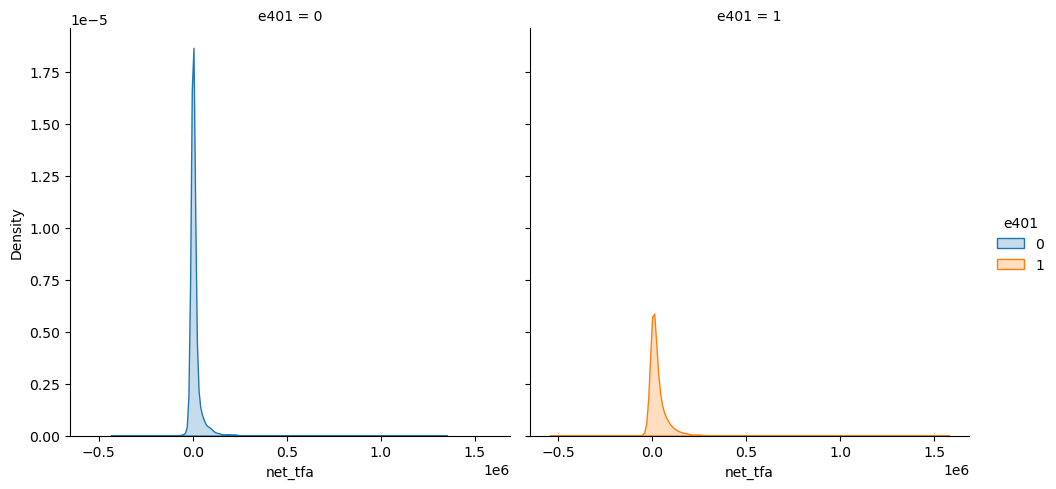

In [7]:
sns.displot(data=data, x='net_tfa', kind='kde', col='e401', hue='e401', fill=True)
plt.show()

The unconditional APE of e401 is about $19559$:

In [8]:
e1 = data[data['e401'] == 1]['net_tfa']
e0 = data[data['e401'] == 0]['net_tfa']
print(f'{np.mean(e1) - np.mean(e0):.0f}')

19559


Among the $3682$ individuals that  are eligible, $2594$ decided to participate in the program. The unconditional APE of p401 is about $27372$:

In [9]:
e1 = data[data['p401'] == 1]['net_tfa']
e0 = data[data['p401'] == 0]['net_tfa']
print(f'{np.mean(e1) - np.mean(e0):.0f}')

27372


As discussed, these estimates are biased since they do not account for saver heterogeneity and endogeneity of participation.

In [10]:
y = data['net_tfa'].values
D = data['e401'].values
D2 = data['p401'].values
D3 = data['a401'].values
X = data.drop(['e401', 'p401', 'a401', 'tw', 'tfa', 'net_tfa', 'tfa_he',
               'hval', 'hmort', 'hequity',
               'nifa', 'net_nifa', 'net_n401', 'ira',
               'dum91', 'icat', 'ecat', 'zhat',
               'i1', 'i2', 'i3', 'i4', 'i5', 'i6', 'i7',
               'a1', 'a2', 'a3', 'a4', 'a5'], axis=1)
X.columns

Index(['age', 'inc', 'fsize', 'educ', 'db', 'marr', 'male', 'twoearn', 'pira',
       'nohs', 'hs', 'smcol', 'col', 'hown'],
      dtype='object')

### We define a transformer that constructs the engineered features for controls

In [11]:
!pip install formulaic

Defaulting to user installation because normal site-packages is not writeable


In [12]:
from sklearn.base import TransformerMixin, BaseEstimator
from formulaic import Formula

class FormulaTransformer(TransformerMixin, BaseEstimator):
    
    def __init__(self, formula, array=False):
        self.formula = formula
        self.array = array
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        df = Formula(self.formula).get_model_matrix(X)
        if self.array:
            return df.values
        return df

In [13]:
transformer = FormulaTransformer("0 + poly(age, degree=6, raw=True) + poly(inc, degree=8, raw=True) "
                                 "+ poly(educ, degree=4, raw=True) + poly(fsize, degree=2, raw=True) "
                                 "+ male + marr + twoearn + db + pira + hown")

In [14]:
transformer.fit_transform(X).describe()

,db,hown,male,marr,pira,"poly(age, degree=6, raw=True)[0]","poly(age, degree=6, raw=True)[1]","poly(age, degree=6, raw=True)[2]","poly(age, degree=6, raw=True)[3]","poly(age, degree=6, raw=True)[4]",...,"poly(fsize, degree=2, raw=True)[1]","poly(inc, degree=8, raw=True)[0]","poly(inc, degree=8, raw=True)[1]","poly(inc, degree=8, raw=True)[2]","poly(inc, degree=8, raw=True)[3]","poly(inc, degree=8, raw=True)[4]","poly(inc, degree=8, raw=True)[5]","poly(inc, degree=8, raw=True)[6]","poly(inc, degree=8, raw=True)[7]",twoearn
count,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9.915000e+03,9.915000e+03,...,9915.000000,9915.000000,9.915000e+03,9.915000e+03,9.915000e+03,9.915000e+03,9.915000e+03,9.915000e+03,9.915000e+03,9915.000000
mean,0.271004,0.635199,0.205951,0.604841,0.242158,41.060212,1792.938981,82850.255371,4.022991e+06,2.036867e+08,...,10.581241,37200.623197,1.997590e+09,1.437534e+14,9.104568e+17,-1.945721e+16,-9.132838e+16,1.934747e+16,2.234841e+16,0.380837
std,0.444500,0.481399,0.404415,0.488909,0.428411,10.344505,899.134499,61725.701911,3.939869e+06,2.448502e+08,...,11.391608,24774.288006,3.026128e+09,4.129207e+14,3.249753e+18,5.290488e+18,5.317962e+18,5.317873e+18,5.262071e+18,0.485617
min,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,625.000000,15625.000000,3.906250e+05,9.765625e+06,...,1.000000,-2652.000000,0.000000e+00,-1.865179e+10,-9.222694e+18,-9.221958e+18,-9.221276e+18,-9.223372e+18,-9.221563e+18,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000,1024.000000,32768.000000,1.048576e+06,3.355443e+07,...,4.000000,19413.000000,3.768646e+08,7.316072e+12,3.677463e+16,-4.537058e+18,-4.603302e+18,-4.539584e+18,-4.508422e+18,0.000000
50%,0.000000,1.000000,0.000000,1.000000,0.000000,40.000000,1600.000000,64000.000000,2.560000e+06,1.024000e+08,...,9.000000,31476.000000,9.907386e+08,3.118449e+13,4.226261e+17,3.660147e+16,-2.199258e+17,3.665403e+16,4.447478e+16,0.000000
75%,1.000000,1.000000,0.000000,1.000000,0.000000,48.000000,2304.000000,110592.000000,5.308416e+06,2.548040e+08,...,16.000000,48583.500000,2.360356e+09,1.146744e+14,2.117477e+18,4.485390e+18,4.471642e+18,4.613388e+18,4.509509e+18,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,64.000000,4096.000000,262144.000000,1.677722e+07,1.073742e+09,...,169.000000,242124.000000,5.862403e+10,1.419428e+16,9.222042e+18,9.218801e+18,9.219035e+18,9.223289e+18,9.220028e+18,1.000000


In [15]:
transformer = FormulaTransformer("0 + poly(age, degree=6, raw=True) + poly(inc, degree=8, raw=True) "
                                 "+ poly(educ, degree=4, raw=True) + poly(fsize, degree=2, raw=True) "
                                 "+ male + marr + twoearn + db + pira + hown", array=True)

# Effect of Eligibility on Financial Assets

In [16]:
modely = make_pipeline(transformer, StandardScaler(), LassoCV())
modeld = make_pipeline(transformer, StandardScaler(), LassoCV())

In [17]:
resy = y - modely.fit(X, y).predict(X)
resD = D - modeld.fit(X, D).predict(X)

In [18]:
np.mean(resy * resD) / np.mean(resD**2)

9018.119246620929

# Instrumental Variables: Effect of 401k on Financial Assets

In [19]:
modely = make_pipeline(transformer, StandardScaler(), LassoCV())
modeld = make_pipeline(transformer, StandardScaler(), LassoCV())
modelz = make_pipeline(transformer, StandardScaler(), LassoCV())

In [21]:
resy = y - modely.fit(X, y).predict(X)
resD = D - modeld.fit(X, D).predict(X) # instrument is e401k (eligibility)
resD2 = D2 - modelz.fit(X, D2).predict(X) # treatment is p401k (participation)

In [22]:
np.mean(resy * resD) / np.mean(resD2 * resD)

12959.476983995874